In [ ]:
!pip install tensorflow_decision_forests

In [1]:
import sklearn
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib

In [2]:
base_df = pd.read_csv(os.path.join('naradatasetv4.csv'), sep=',', dtype=float)
nrows, ncols = base_df.shape
print(f'Loaded {nrows} rows and {ncols} columns')

# let's go ahead and shuffle the order of the rows in case there's any collection bias
base_df = base_df.sample(frac=1).reset_index(drop=True)
base_df = base_df.iloc[:, :300]
base_df.head()

Loaded 5171 rows and 306 columns


,Age 0_20,Age 21_30,Age 31,Gender_Male,Gender_Female,Gender_Non_Binary,Work,Family,Social,Institution,...,Z_defended_themselves,X_got_experienced_help,Z_got_experienced_help,X_asked_for_advice_from_their_community,Z_asked_for_advice_from_their_community,X_talked_to_someone_who_is_affected,Z_talked_to_someone_who_is_affected,X_got_someone_else_involved,Z_got_someone_else_involved,Positive_Negative_Outcome
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to start by one-hot encoding all of the categorical attributes (e.g., environment, age, etc.) as binary indicator variables.

In [3]:
# get a dataframe containing only the binary attributes
binary_cols_df = base_df.iloc[:, 0:35]
binary_cols_df = pd.concat([binary_cols_df, base_df.iloc[:, 35:202]], axis=1)
binary_cols_df = binary_cols_df.dropna()

print(binary_cols_df.columns)

binary_cols_df.head()
binary_cols_df.shape

Index(['Age 0_20', 'Age 21_30', 'Age 31', 'Gender_Male', 'Gender_Female',
       'Gender_Non_Binary', 'Work', 'Family', 'Social', 'Institution',
       ...
       'X_defended_themselves', 'Z_defended_themselves',
       'X_got_experienced_help', 'Z_got_experienced_help',
       'X_asked_for_advice_from_their_community',
       'Z_asked_for_advice_from_their_community',
       'X_talked_to_someone_who_is_affected',
       'Z_talked_to_someone_who_is_affected', 'X_got_someone_else_involved',
       'Z_got_someone_else_involved'],
      dtype='object', length=167)


(3004, 167)

In [4]:
pd.options.display.max_rows
pd.set_option('display.max_rows', None)
binary_cols_df.sum(axis=0)

Age 0_20                                                    641.0
Age 21_30                                                  1568.0
Age 31                                                      795.0
Gender_Male                                                1810.0
Gender_Female                                              1182.0
Gender_Non_Binary                                            12.0
Work                                                        626.0
Family                                                      693.0
Social                                                     1412.0
Institution                                                 273.0
Employee                                                     94.0
Boss                                                        340.0
Colleague                                                    87.0
Customer                                                    105.0
Parent                                                      294.0
Sibling   

In [5]:
# get a dataframe containing the class attributes
class_cols_df = base_df.iloc[:, 203:300]
class_cols_df = class_cols_df.dropna()

print(class_cols_df.columns)
class_cols_df.head()
class_cols_df.shape

Index(['X_began_or_returned_to_a_relationship_with_Z',
       'X_is_leaving_the_relationship', 'Z_is_leaving_the_relationship',
       'X_did_not_try_to_make_the_relationship_work',
       'Z_did_not_try_to_make_the_relationship_work',
       'X_made_Z_feel_uncomfortable', 'Z_made_X_feel_uncomfortable',
       'X_criticized_and_complained', 'Z_criticized_and_complained',
       'X_blamed_and_accused',
       ...
       'X_asked_for_help_and_support', 'Z_asked_for_help_and_support',
       'X_is_trying_to_understand_the_situation',
       'Z_is_trying_to_understand_the_situation',
       'X_is_figuring_out_what_to_do', 'Z_is_figuring_out_what_to_do',
       'X_is_rationalizing_the_situation', 'Z_is_rationalizing_the_situation',
       'X_does_not_know_what_to_do', 'Z_does_not_know_what_to_do'],
      dtype='object', length=137)


(3004, 137)

In [6]:
# let's look at the support for each of the classes
class_cols_df.sum(axis=0)

X_began_or_returned_to_a_relationship_with_Z           460.0
X_is_leaving_the_relationship                          301.0
Z_is_leaving_the_relationship                          107.0
X_did_not_try_to_make_the_relationship_work            278.0
Z_did_not_try_to_make_the_relationship_work            820.0
X_made_Z_feel_uncomfortable                            145.0
Z_made_X_feel_uncomfortable                            493.0
X_criticized_and_complained                            196.0
Z_criticized_and_complained                            582.0
X_blamed_and_accused                                   125.0
Z_blamed_and_accused                                   377.0
X_is_being_hurtful_and_disrespectful                   145.0
Z_is_being_hurtful_and_disrespectful                   727.0
X_is_being_manipulative_to_get_what_they_want          106.0
Z_is_being_manipulative_to_get_what_they_want          729.0
X_is_pressuring_and_controlling                        129.0
Z_is_pressuring_and_cont

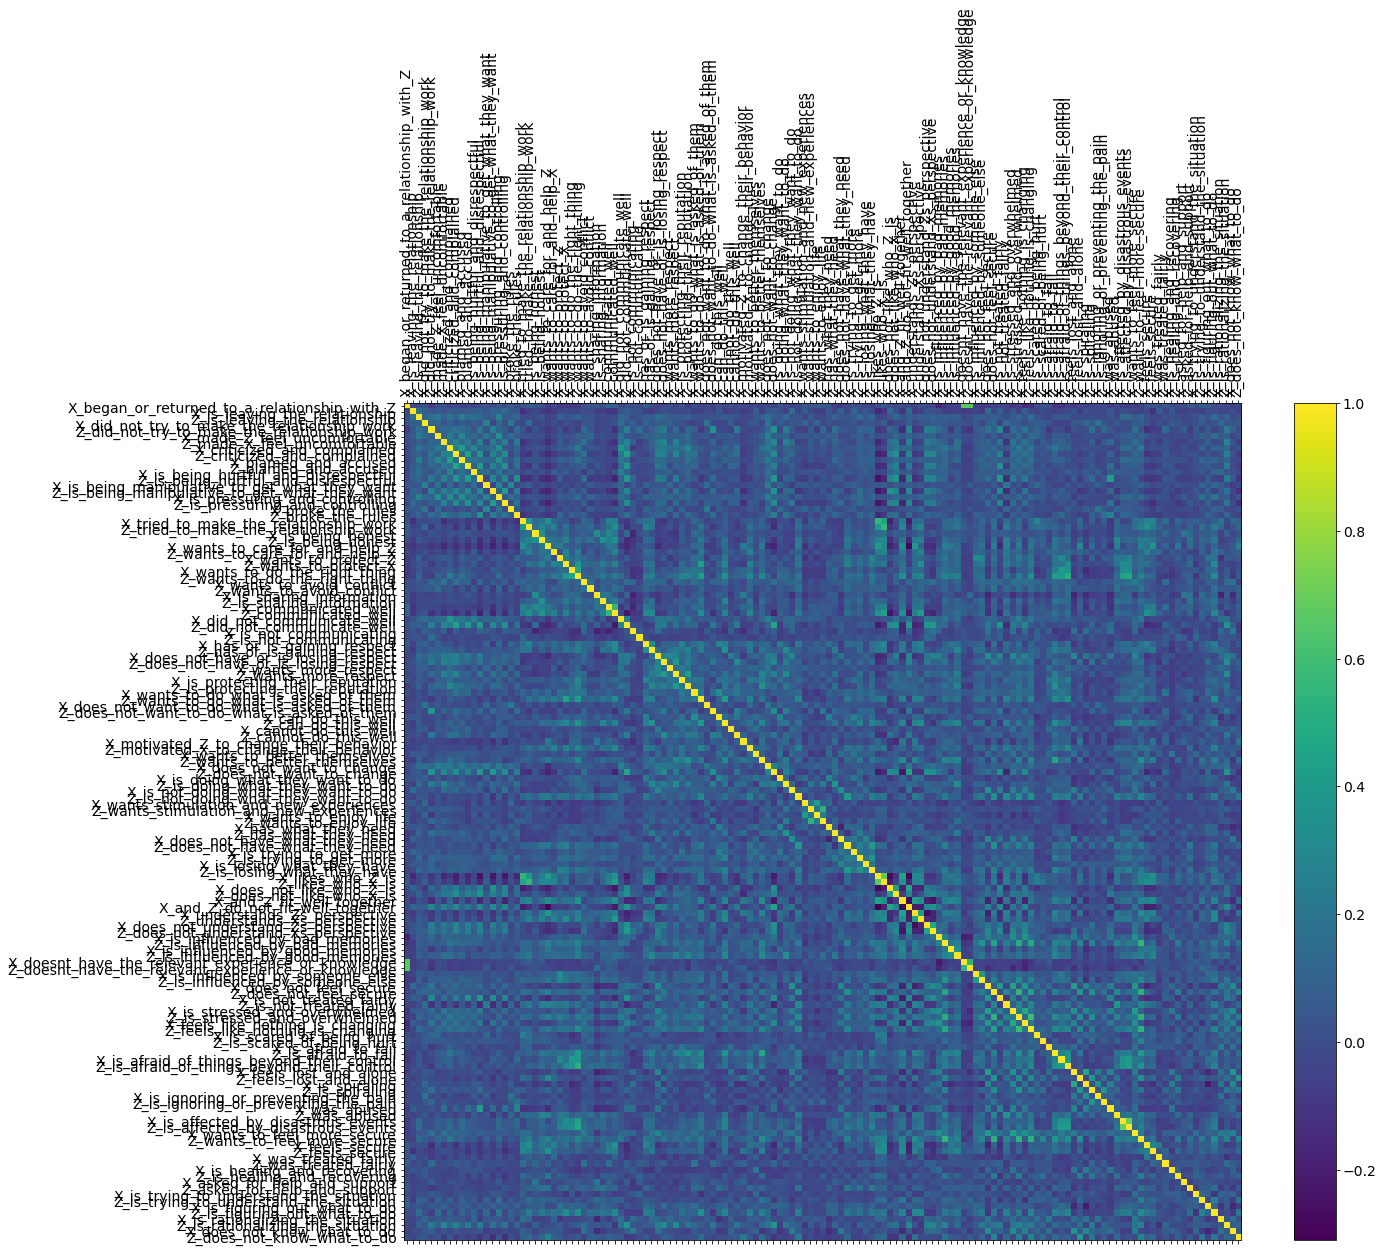

In [7]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(class_cols_df.corr(), fignum=f.number)
plt.xticks(range(class_cols_df.shape[1]), class_cols_df.columns, fontsize=14, rotation=90)
plt.yticks(range(class_cols_df.shape[1]), class_cols_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)


### The function below will train and test a given classifier on a random train/test split of the dataset. To account for the stochastic nature of the dataset splitting and the training of the classifier itself, we will perform the train and test operations many time (e.g., 100 or 1000) and average the results (ordering to several different metrics) to get the final results.

In [8]:
from sklearn.metrics import roc_auc_score, f1_score
from scipy.spatial.distance import jaccard
from sklearn.metrics import hamming_loss
import numpy as np
import tensorflow_decision_forests as tfdf

def train_and_test_model(clf, X_df, Y_df, test_sz, threshold=0.3, ntrials=100, eval_on_train=False, skmulti=False):
    metrics = [('Jaccard', jaccard, lambda x: 1.0 - x), ('Hamming', hamming_loss, lambda x: 1.0 - x)]
    metric_scores = {m: [] for m, _, _ in metrics }
    metric_scores['AUC'] = []
    metric_scores['F1'] = []
    auc_failed = f1_failed = 0
    report_interval = max(int(ntrials/10), 1)
    if eval_on_train:
        print('Evaluating on the training set...')
    for it in range(ntrials):
        # split the data into train and test sets
        if eval_on_train:
            X_train, X_test, y_train, y_test = X_df, X_df, Y_df, Y_df
        else:
            X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=test_sz)
        # train the model
        if skmulti:
            X_train = X_train.to_numpy()
            y_train = y_train.to_numpy()
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, y_train, label="label")
        clf.fit(train_ds)

        # inference the model on the test set. For each test example, we'll get a vector of length n_classes, where
        # the value at index i is the probability of class i being Yes.

        if skmulti:
            y_pred = clf.predict(X_test)
        else:
            y_pred = clf.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_test))

        probs = []
        preds = []
        truths = []

        if skmulti:
            for i in range(len(X_test)):
                preds.append(np.array(y_pred[i] > threshold, dtype=int))
                truths.append(np.array(y_test.iloc[i, :], dtype=int))
        else:
            for i, row in enumerate(y_pred):
                preds.append(np.array(row > threshold, dtype=int))
                truths.append(np.array(y_test.iloc[i, :], dtype=int))

        for met_name, metric, fn in metrics:
            met_total = 0.0
            for i in range(len(X_test)):
                met_total += fn(metric(truths[i], preds[i]))
            metric_scores[met_name].append(met_total / len(X_test))

        # compute ROC AUC
        try:
            if skmulti:
                y_pred_proba = clf.predict_proba(X_test)
                metric_scores['AUC'].append(roc_auc_score(np.array(y_test), y_pred_proba, average='weighted'))
            else:
                y_pred_proba = clf.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_test), output_probabilities=True)
                metric_scores['AUC'].append(roc_auc_score(np.array(y_test), y_pred_proba, average='weighted', multi_class='ovr'))
        except ValueError:
            auc_failed += 1

        # compute F1
        try:
            metric_scores['F1'].append(f1_score(truths, preds, average='weighted'))
        except:
            f1_failed += 1

        if it % report_interval == 0:
            print(f'Finished {it} / {ntrials} iterations')
    for name, scores in metric_scores.items():
        avg_score = np.average(scores)
        print(f'{name}:\t{avg_score:.3}')
    print(f'Failed to compute AUC on {auc_failed} itertions')
    print(f'Failed to compute F1 on {f1_failed} itertions')
    return truths, preds



ModuleNotFoundError: No module named 'yggdrasil_decision_forests'

In [4]:
from tensorflow import keras

keras.RandomForestModel()

AttributeError: module 'keras.api._v2.keras' has no attribute 'RandomForestModel'

### Now that we have a dataframe containing all binary attributes and another containing all of our class attributes, we're ready to train a model. We'll start by training a Random Forest model, as it supports multi-label formulations and generally gives good results for many problems.

#### Random Forest is a perturb-and-combine techniques specifically designed for decision trees. This means a diverse set of classifiers (decision trees in this case) is created by introducing randomness into the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.454
Hamming:	0.858
AUC:	0.854
F1:	0.614
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.1, threshold=0.3, ntrials=100)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.46
Hamming:	0.86
AUC:	0.859
F1:	0.62
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


In [11]:
# let's increase the number of estimators used in the random forest fro 100 to 250 and see that improves the results
clf = RandomForestClassifier(n_estimators=250, n_jobs=6) #, class_weight='balanced')
_, _ = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.458
Hamming:	0.859
AUC:	0.861
F1:	0.618
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


In [12]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=6, max_features="sqrt") #, class_weight='balanced')
_, _ = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.2, ntrials=100)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.435
Hamming:	0.806
AUC:	0.856
F1:	0.606
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


In [13]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=6, max_features="sqrt") #, class_weight='balanced')
_, _ = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=1000)

Finished 0 / 1000 iterations
Finished 100 / 1000 iterations
Finished 200 / 1000 iterations
Finished 300 / 1000 iterations
Finished 400 / 1000 iterations
Finished 500 / 1000 iterations
Finished 600 / 1000 iterations
Finished 700 / 1000 iterations
Finished 800 / 1000 iterations
Finished 900 / 1000 iterations
Jaccard:	0.454
Hamming:	0.858
AUC:	0.855
F1:	0.614
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


### Let's look at how the classifier does on the trianing set to make sure it's not under-fitting, which would be indicated by low performance on the training set.

In [14]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
_, _ = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100, eval_on_train=True)

Evaluating on the training set...
Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.994
Hamming:	0.999
AUC:	1.0
F1:	0.997
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


### Let's save a model for production

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
_, _ = train_and_test_model(clf, binary_cols_df, class_cols_df, 0, threshold=0.3, ntrials=1, eval_on_train=True)
joblib.dump(clf, os.path.join('SB_clf.pkl'))

Evaluating on the training set...
Finished 0 / 1 iterations
Jaccard:	0.993
Hamming:	0.999
AUC:	1.0
F1:	0.998
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


['models/main_clf.pkl']

### Feature Importances
#### Let's look at which features most important to the model. The fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature. The higher the score, the more important the feature. Note that the scores are normalized and thus sum to 1.0.

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=1)
feature_imp = list(zip(clf.feature_importances_, binary_cols_df.columns))
feature_imp.sort(reverse=True)
#feature_imp = pd.Series(clf.feature_importances_, index=binary_cols_df.columns).sort_values(ascending=False)

for score, name in feature_imp:
    print(f'{name:40} {score}')

Finished 0 / 1 iterations
Jaccard:	0.462
Hamming:	0.859
AUC:	0.86
F1:	0.626
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions
Caring                                   0.017479609199473493
Neuroticism_Withdrawal                   0.014027546589176399
Agitation                                0.013879396641471928
Negative_and_Passive                     0.013535724429345738
Positive_Thoughts                        0.01340111266795898
Negative_and_Forceful                    0.012748047510539495
Benevolence_Dependability                0.012603402406326722
Negative_Not_in_Control                  0.011494400359051487
Honesty_Humility_Fairness                0.011335945398879235
Agreeableness_Compassion                 0.011237850885186012
Reactive                                 0.010821797214427617
Achievement                              0.010692099776934739
Face                                     0.010590057752573158
Extraversion_Enthusiasm                  0.010

In [17]:
# top 40 features
feats = [x[1] for x in feature_imp]
X_select = binary_cols_df[feats[:40]]
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
truths, preds = train_and_test_model(clf, X_select, class_cols_df, 0.2, threshold=0.3, ntrials=100)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.444
Hamming:	0.85
AUC:	0.837
F1:	0.608
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


TODO: UPDATE

It seems that we can eliminate about 15 distinct attributes (34 features) with only a negligable impact on accuracy:

Caring                              
Conformity - Rules                  
Conscientiousness - Industriousness 
Ethnicity
Hedonism                            
Humility                            
Positive and Lively                 
Quiet Positive                      
Reactive                            
Security - Societal                 
Self-Direction - Action             
Tradition                           
Universalism - Concern              
Universalism - Nature               
Universalism - Tolerance

In [18]:
# top 10 features only
feats = [x[1] for x in feature_imp]
X_select = binary_cols_df[feats[:10]]
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
truths, preds = train_and_test_model(clf, X_select, class_cols_df, 0.2, threshold=0.3, ntrials=100)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.358
Hamming:	0.805
AUC:	0.74
F1:	0.53
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


In [19]:
# top 20 features only
feats = [x[1] for x in feature_imp]
X_select = binary_cols_df[feats[:20]]
clf = RandomForestClassifier(n_estimators=100, n_jobs=6) #, class_weight='balanced')
truths, preds = train_and_test_model(clf, X_select, class_cols_df, 0.2, threshold=0.3, ntrials=100)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations
Finished 40 / 100 iterations
Finished 50 / 100 iterations
Finished 60 / 100 iterations
Finished 70 / 100 iterations
Finished 80 / 100 iterations
Finished 90 / 100 iterations
Jaccard:	0.404
Hamming:	0.828
AUC:	0.789
F1:	0.575
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions


In [20]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=6, max_features="sqrt") #, class_weight='balanced')
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=1)
from sklearn.metrics import classification_report
print(classification_report(truths, preds, target_names=list(class_cols_df.columns)))
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(truths, preds)

Finished 0 / 1 iterations
Jaccard:	0.454
Hamming:	0.857
AUC:	0.85
F1:	0.607
Failed to compute AUC on 0 itertions
Failed to compute F1 on 0 itertions
                                                    precision    recall  f1-score   support

      X_began_or_returned_to_a_relationship_with_Z       0.58      0.36      0.45        96
                     X_is_leaving_the_relationship       0.48      0.27      0.35        59
                     Z_is_leaving_the_relationship       0.83      0.26      0.40        19
       X_did_not_try_to_make_the_relationship_work       1.00      0.07      0.14        69
       Z_did_not_try_to_make_the_relationship_work       0.55      0.81      0.65       160
                       X_made_Z_feel_uncomfortable       1.00      0.27      0.42        26
                       Z_made_X_feel_uncomfortable       0.59      0.48      0.53       106
                       X_criticized_and_complained       0.95      0.44      0.60        43
                      

array([[[480,  25],
        [ 61,  35]],

       [[525,  17],
        [ 43,  16]],

       [[581,   1],
        [ 14,   5]],

       [[532,   0],
        [ 64,   5]],

       [[334, 107],
        [ 30, 130]],

       [[575,   0],
        [ 19,   7]],

       [[459,  36],
        [ 55,  51]],

       [[557,   1],
        [ 24,  19]],

       [[419,  59],
        [ 40,  83]],

       [[570,   2],
        [ 21,   8]],

       [[502,  19],
        [ 55,  25]],

       [[579,   0],
        [ 17,   5]],

       [[375,  81],
        [ 43, 102]],

       [[578,   1],
        [ 20,   2]],

       [[370,  97],
        [ 35,  99]],

       [[574,   0],
        [ 21,   6]],

       [[415,  60],
        [ 41,  85]],

       [[580,   0],
        [ 19,   2]],

       [[541,   3],
        [ 44,  13]],

       [[294,  91],
        [ 35, 181]],

       [[476,  41],
        [ 38,  46]],

       [[490,  22],
        [ 70,  19]],

       [[551,   3],
        [ 40,   7]],

       [[440,  38],
        [ 21, 

### SkMultilearn classifiers

The binary relevance classifier works the same way as sklearn's built-in handling of multilabel classification, as was done above. The approach transforms a multi-label classification problem with L labels into L single-label separate binary classification problems using the same base classifier provided in the constructor. The prediction output is the union of all per label classifiers. Unlike Sklearn, we can try a larger variety of base classifiers with skmultilearn's wrapper.

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
clf = BinaryRelevance(classifier = SVC(probability=True), require_dense = [True, True])
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100, skmulti=True)

Finished 0 / 100 iterations
Finished 10 / 100 iterations
Finished 20 / 100 iterations
Finished 30 / 100 iterations


In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
clf = BinaryRelevance(classifier = SVC(probability=True, gamma='scale', kernel='rbf', C=4), require_dense = [True, True])
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=10, skmulti=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = BinaryRelevance(classifier = LogisticRegression(max_iter=500), require_dense = [True, True])
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100, skmulti=True)

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.neural_network import MLPClassifier
clf = BinaryRelevance(classifier=MLPClassifier(alpha=1, max_iter=1000), require_dense = [True, True])
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=1, skmulti=True)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = BinaryRelevance(classifier = KNeighborsClassifier(), require_dense = [True, True])
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100, skmulti=True)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf = BinaryRelevance(classifier = ExtraTreesClassifier(criterion='entropy'), require_dense = [True, True])
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=10, skmulti=True)

Let's try some of the more advanced multilabel classifiers provided by Skmultilearn

In [ ]:
from skmultilearn.adapt import MLkNN, BRkNNaClassifier, MLARAM
clf = MLARAM(threshold=0.05, vigilance=0.95) #MLkNN(k=3)
truths, preds = train_and_test_model(clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=1, skmulti=True)

### Baseline (dummy) classifiers
#### To better interpret the results we're seeing above, let's look at how a dummy classifier that just generates predictions by respecting the training set’s class distribution woudl do in this dataset.

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf =  DummyClassifier(strategy='stratified')
_, preds_dummy = train_and_test_model(dummy_clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100)

In [ ]:
dummy_clf =  DummyClassifier(strategy='prior')
_, preds_dummy = train_and_test_model(dummy_clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100)

In [ ]:
dummy_clf =  DummyClassifier(strategy='uniform')
_, preds_dummy = train_and_test_model(dummy_clf, binary_cols_df, class_cols_df, 0.2, threshold=0.3, ntrials=100)